In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
!apt-get install tree
# create new folders
!mkdir TRAIN TEST TRAIN/YES TRAIN/NO TEST/YES TEST/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 0s (301 kB/s)
Selecting previously unselected package tree.
(Reading database ... 122352 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...
.
├── drive
│   └── MyDrive
│       ├── Colab Notebooks
│       │   ├── Datasets
│       │   │   ├── Brain tumor detection
│       │   │   │   ├── no
│       │   │   │   └── yes
│       │   │   └── GTSRB Dataset
│       │   │       ├── Meta
│       │   │       ├── Test
│       │   │       

In [ ]:
IMG_PATH = '/content/drive/MyDrive/Colab Notebooks/Datasets/Brain tumor detection/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    print(os.listdir(IMG_PATH))
    if not CLASS.startswith('.') and CLASS != 'brain_tumor_dataset':
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)

['no', 'yes']
98
['no', 'yes']
155


In [ ]:
dataset_dir = "/content/TRAIN"
test_dir = "/content/TEST"

In [ ]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=32

In [ ]:
def image_gen(height, width, batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.1,
    )

    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    val_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="validation",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )
    
    test_gen = ImageDataGenerator(
        rescale=1./255.
    )
    
    test_ds = test_gen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    return train_ds, val_ds, test_ds

In [ ]:
def augmented_data(height, width):
    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )
    
    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )
    
    return train_ds

In [ ]:
train_ds, val_ds, test_ds = image_gen(height, width)

total_images = np.concatenate([train_ds.labels, val_ds.labels, test_ds.labels])

# Print the count of images in each class
print({"No brain tumor cases": len(np.where(total_images == 0)[0]),
       "Brain tumor cases": len(np.where(total_images == 1)[0])})

Found 219 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
{'No brain tumor cases': 98, 'Brain tumor cases': 155}


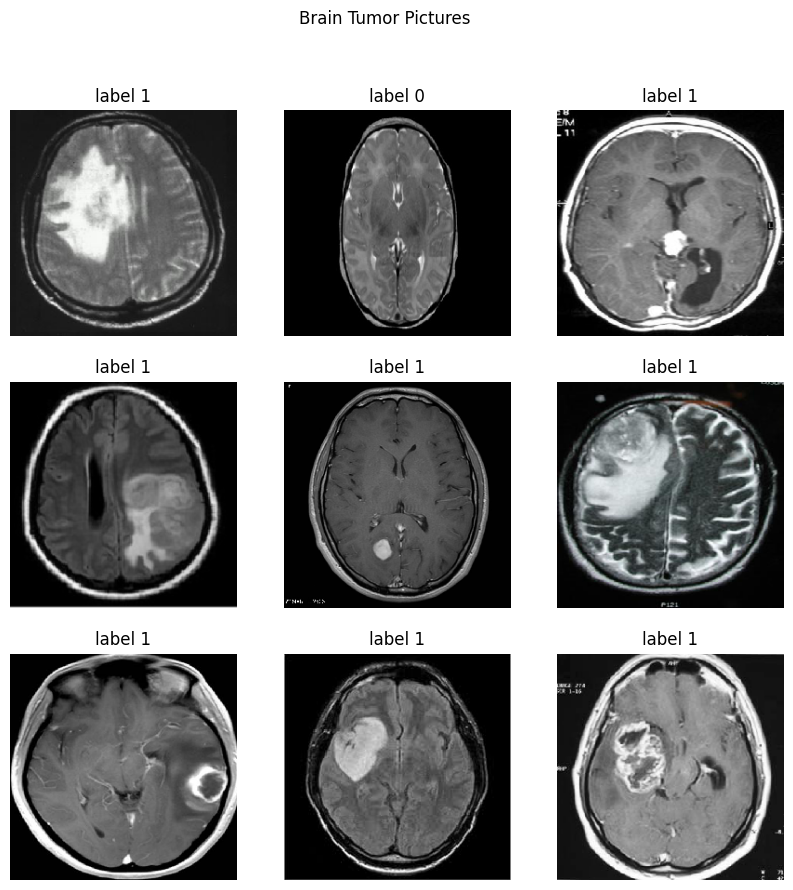

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
fig.suptitle("Brain Tumor Pictures")

for k in range(9):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//3, k%3
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"label {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

In [ ]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model

In [ ]:
#Declaring base model
tf.keras.backend.clear_session()

base_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
base_model.trainable = False

model1 = Sequential([
    base_model, 
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model1.compile(optimizer=Adam(), 
               loss="sparse_categorical_crossentropy", 
               metrics=['accuracy'])

model1.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 51

In [ ]:
history = model1.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
7/7 [==============================] - 39s 5s/step - loss: 0.7504 - accuracy: 0.6530 - val_loss: 0.2209 - val_accuracy: 0.9167
Epoch 2/15
7/7 [==============================] - 34s 5s/step - loss: 0.3642 - accuracy: 0.8539 - val_loss: 0.3370 - val_accuracy: 0.7500
Epoch 3/15
7/7 [==============================] - 34s 5s/step - loss: 0.2517 - accuracy: 0.9041 - val_loss: 0.2556 - val_accuracy: 0.9167
Epoch 4/15
7/7 [==============================] - 34s 5s/step - loss: 0.1516 - accuracy: 0.9452 - val_loss: 0.1956 - val_accuracy: 0.9167
Epoch 5/15
7/7 [==============================] - 34s 5s/step - loss: 0.1399 - accuracy: 0.9452 - val_loss: 0.2034 - val_accuracy: 0.9583
Epoch 6/15
7/7 [==============================] - 35s 5s/step - loss: 0.0865 - accuracy: 0.9680 - val_loss: 0.1720 - val_accuracy: 0.9583
Epoch 7/15
7/7 [==============================] - 34s 5s/step - loss: 0.0736 - accuracy: 0.9817 - val_loss: 0.1661 - val_accuracy: 0.9583
Epoch 8/15
7/7 [==================

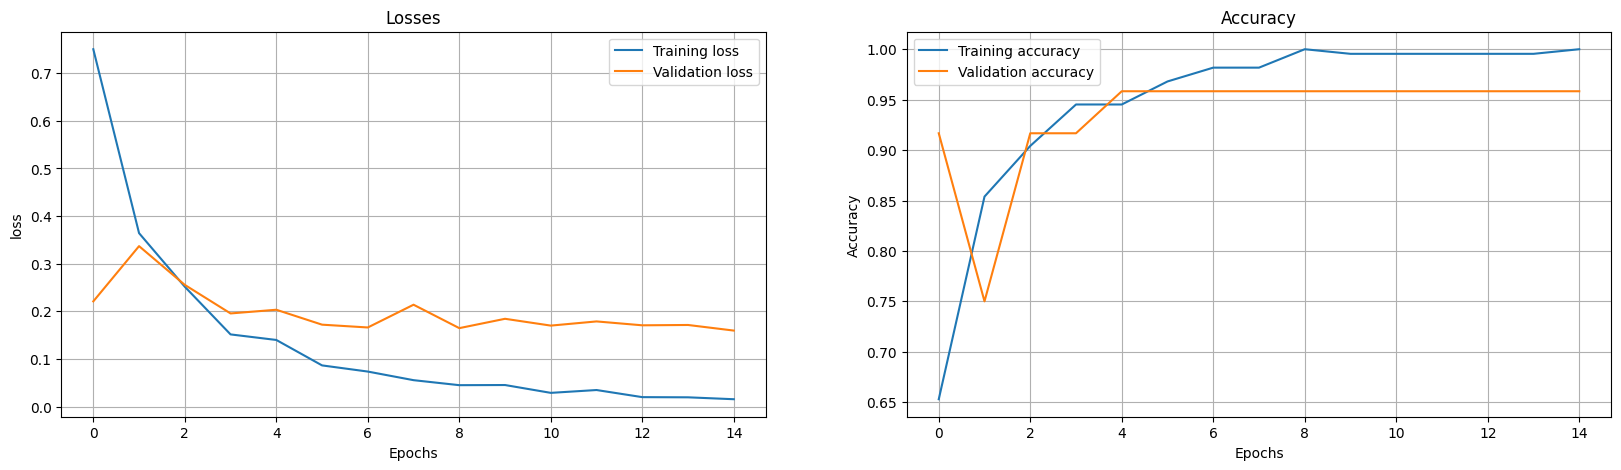

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [ ]:
aug_train_ds = augmented_data(height, width)
history = model1.fit(aug_train_ds, validation_data=val_ds, epochs=15)

Found 243 images belonging to 2 classes.
Epoch 1/15
8/8 [==============================] - 39s 5s/step - loss: 0.3025 - accuracy: 0.8807 - val_loss: 0.0522 - val_accuracy: 1.0000
Epoch 2/15
8/8 [==============================] - 40s 5s/step - loss: 0.1985 - accuracy: 0.9218 - val_loss: 0.1204 - val_accuracy: 0.9583
Epoch 3/15
8/8 [==============================] - 40s 5s/step - loss: 0.1927 - accuracy: 0.9342 - val_loss: 0.1717 - val_accuracy: 0.9167
Epoch 4/15
8/8 [==============================] - 38s 5s/step - loss: 0.1634 - accuracy: 0.9136 - val_loss: 0.1066 - val_accuracy: 0.9583
Epoch 5/15
8/8 [==============================] - 41s 5s/step - loss: 0.1302 - accuracy: 0.9506 - val_loss: 0.0278 - val_accuracy: 1.0000
Epoch 6/15
8/8 [==============================] - 41s 5s/step - loss: 0.1410 - accuracy: 0.9465 - val_loss: 0.0447 - val_accuracy: 1.0000
Epoch 7/15
8/8 [==============================] - 40s 5s/step - loss: 0.1604 - accuracy: 0.9424 - val_loss: 0.1195 - val_accuracy: 

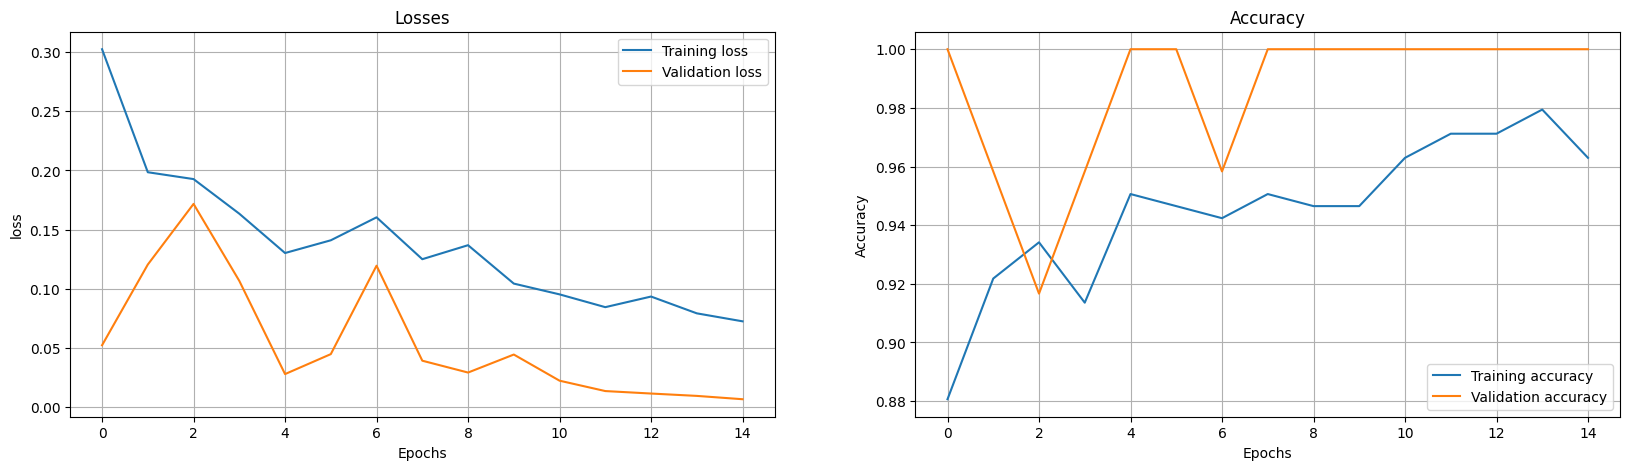

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()